<figure>
  <IMG src="figures/logo-esi-sba.png" WIDTH=300 height="100" ALIGN="right">
</figure>

# Practical Trainining Series on Modeling And Simulation   
*By Dr. Belkacem KHALDI (b.khaldi@esi-sba.dz)*

## Notebook 7: Modeling and Simulating Discrete-Event Systems
<figure>
  <IMG src="figures/ch7-des-fig1.png" WIDTH=400 height="400" ALIGN="right">
</figure>

In this Notebook you learn how to model and simulate Discerte-Event systems using simpy python library.
Discrete-Event Systems are a type of systems that are driven by discret-events. The state of such systems is changed whenever an event occures. The occurence of an event is mostely stochastic in time and therefore the  inter-arival events time is discret. 

### simpy
SimPy is a discrete-event simulation library. The behavior of active components (like vehicles, customers or messages) is modeled with processes. All processes live in an environment. They interact with the environment and with each other via events.

 First of all we will need the simpy python library to simulate such systens    

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install simpy
import simpy


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Our First Process
Let's simulate our first example which will be about a Customer visiting a Bank. We assume that the Bank is always full of customers and when the visitor arrives, he will stay just 10 minites there and then leave the Bank without even being served. We assume also that our customer will frequently visit the Bank each 30 minutes and he will alternately arrive and leave for a while. When he arrives (or leaves) the Bank, we will print and save both the current sate and simulation time. So, the customer switches between the states arriving and departure.

Mr. KHALDI Arrives at the Bank at 0
Mr. KHALDI leaves the Bank at 10
Mr. KHALDI Arrives at the Bank at 40
Mr. KHALDI leaves the Bank at 50
Mr. KHALDI Arrives at the Bank at 80
Mr. KHALDI leaves the Bank at 90


Text(0, 0.5, 'State')

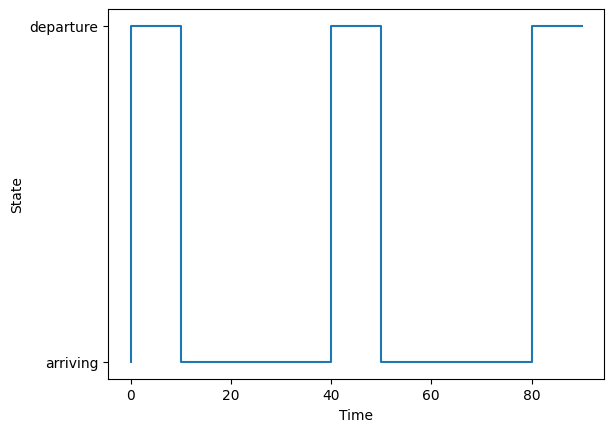

In [2]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt

arriving_duration = 10
departure_duration = 30
simulation_time=120
#A list for saving purposes
events=[]
#Define a customer process that requires a reference to an simpy.Environment (env) in order to create new events
def Customer(env,name):
    # To be runned in infinite loop. 
    while True:
        #Announcing the arriving state by printing a message and the current simulation time
        print('Mr. %s Arrives at the Bank at %d' % (name, env.now))
        #save the actual time and state 
        events.append([env.now,'arriving'])
        
        
        #Create a Timeout event and wait for the event to occur. in a given amount of time
        yield env.timeout(arriving_duration)
        
        
        #Announcing the departure state by printing a message and the current simulation time
        print('Mr. %s leaves the Bank at %d' % (name, env.now))
        #save the actual time and state 
        events.append([env.now,'departure'])
        
        #Create a Timeout event and wait for the event to occur. in a given amount of time
        yield env.timeout(departure_duration)
        
        
# create an instance of Simpy Environment. 
env = simpy.Environment()
#Passing env into our customer process function. 
#Started a process and added to the environment

env.process(Customer(env,'KHALDI'))
#start the simulation by calling run() and passing an end time to it.
env.run(until=simulation_time)

#Create a dataframe from list events and plot
df=pd.DataFrame(events, columns=['time','event'])
plt.step(df['time'],df['event'])
plt.xlabel('Time')
plt.ylabel('State')

### Challenge 1:
Recretae the above scenario by assuming now that the arriving and departure duration are stochastic (random).
#### Hint
Use randint from the random import library

Mr. KHALDI Arrives at the Bank at 0
Mr. KHALDI leaves the Bank at 8
Mr. KHALDI Arrives at the Bank at 30
Mr. KHALDI leaves the Bank at 42
Mr. KHALDI Arrives at the Bank at 73
Mr. KHALDI leaves the Bank at 82
Mr. KHALDI Arrives at the Bank at 110


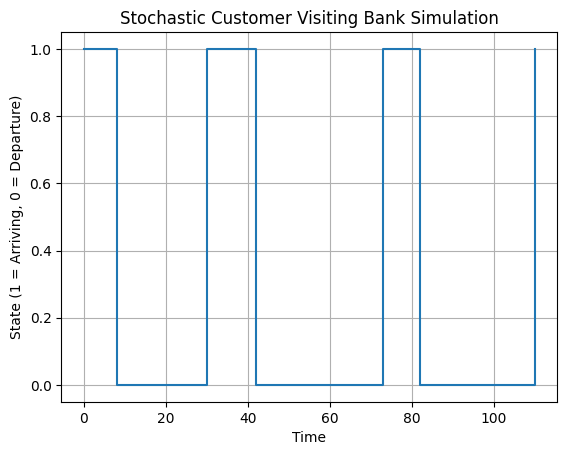

In [5]:
import simpy
import pandas as pd
import matplotlib.pyplot as plt
from random import randint

# Simulation parameters
min_arriving_duration = 5     # Customer stays between 5 to 15 minutes
max_arriving_duration = 15
min_departure_duration = 20   # Customer returns after 20 to 40 minutes
max_departure_duration = 40

simulation_time = 120

# A list for saving events
events = []

# Define a customer process
def Customer(env, name):
    while True:
        # Announcing the arriving state
        print(f'Mr. {name} Arrives at the Bank at {env.now}')
        events.append([env.now, 'arriving'])

        # Random stay duration at the bank
        stay_time = randint(min_arriving_duration, max_arriving_duration)
        yield env.timeout(stay_time)

        # Announcing the departure state
        print(f'Mr. {name} leaves the Bank at {env.now}')
        events.append([env.now, 'departure'])

        # Random time outside before returning
        away_time = randint(min_departure_duration, max_departure_duration)
        yield env.timeout(away_time)

# Create Simpy Environment
env = simpy.Environment()

# Start Customer process
env.process(Customer(env, 'KHALDI'))

# Run the simulation
env.run(until=simulation_time)

# Create a DataFrame from events
df = pd.DataFrame(events, columns=['time', 'event'])

# Map 'arriving' and 'departure' to numeric values for plotting
df['event_code'] = df['event'].map({'arriving': 1, 'departure': 0})

# Plot the timeline
plt.step(df['time'], df['event_code'], where='post')
plt.xlabel('Time')
plt.ylabel('State (1 = Arriving, 0 = Departure)')
plt.title('Stochastic Customer Visiting Bank Simulation')
plt.grid()
plt.show()


## Our Second Process
Let's assume now that our Customer decides to wait for his service at the Bank. We assume that the Bank has one desk that serves all the cutomers with a Queue type notation (D/D/1). The arriver of a customer is set to be each 7 minutes and the time taken to serve a customer is set to be 5 minutes.
### Hint:
This system is of Queue Type Notation D/D/1 because:


In [9]:
"""
Bank example.

Covers:

- Waiting for other processes
- Resources: Resource

Scenario:
  A Bank has a limited number of service desks and defines
  a service processes that takes some (random) time.

  Customer processes arrive at the Bank at a random time. If one Service
  desk is available, they start serving the customer and wait for it
  to finish. If not, they wait until they  use one.

"""
import numpy.random as rnd
import simpy
import pandas as pd


RANDOM_SEED = 42
NUM_DESKS = 1  # Number of service desks in the Bank
SERVICETIME = 5      # Minutes it takes to serve a customer
T_INTER = 10       # Create a customer every ~10 minutes
SIM_TIME = 45     # Simulation time in minutes

events=[]

class Bank(object):
    """A Bank has a limited number of service desks (``NUM_DESKS``) to
    serve customers in parallel.

    Customers have to request one of the service desks. When they got one, they
    be served and wait for the agent to finish their request which 
    takes ``SERVICETIME`` minutes).

    """
    def __init__(self, env, num_desks, service_time):
        self.env = env
        self.desk = simpy.Resource(env, num_desks)
        self.serviceTime = service_time

    def service(self, customer):
        """The service processes. It takes a ``customer`` processes and tries
        to serve it."""
       
        
        yield self.env.timeout(SERVICETIME)
        print("The Bank agent is serving %d%% of %s's service request." %
              (rnd.randint(75, 99), customer))
        events.append([env.now,customer,'in service'])

def customer(env, name, bk):
    """The customer process (each customer has a ``name``) arrives at the Bank
    (``bk``) and requests a service desk.

    It then  waits for the agent to finialize his request and
    leaves to never come back ...

    """
    print('%s arrives at the Bank at %.2f.' % (name, env.now))
    events.append([env.now,name,'arriving'])
    with bk.desk.request() as request:
        #waiting for the customer's turn to be served
        yield request
        events.append([env.now,name,'waiting'])
        print('%s is being served %.2f.' % (name, env.now))
        
        yield env.process(bk.service(name))
        events.append([env.now, name,'departure'])
        print('%s leaves the Bank at %.2f.' % (name, env.now))


def setup(env, num_desks, service_time, t_inter):
    """Create a Bank, a number of initial customers and keep creating customers
    approx. every ``t_inter`` minutes."""
    # Create the Bank
    bk = Bank(env, num_desks, service_time)

    #we assume that at the beginning the 4 customers are already in queue
    for i in range(4):
        env.process(customer(env, 'Customer %d' % i, bk))

    # Create more customers while the simulation is running
    #i=0
    while True:
        yield env.timeout(T_INTER)
        i += 1
        env.process(customer(env, 'Customer %d' % i, bk))


# Setup and start the simulation
print('Bank')


# Create an environment and start the setup process
env = simpy.Environment()
env.process(setup(env, NUM_DESKS, SERVICETIME, T_INTER))

# Execute!
env.run(until=SIM_TIME)

Bank
Customer 0 arrives at the Bank at 0.00.
Customer 1 arrives at the Bank at 0.00.
Customer 2 arrives at the Bank at 0.00.
Customer 3 arrives at the Bank at 0.00.
Customer 0 is being served 0.00.
The Bank agent is serving 86% of Customer 0's service request.
Customer 0 leaves the Bank at 5.00.
Customer 1 is being served 5.00.
Customer 4 arrives at the Bank at 10.00.
The Bank agent is serving 83% of Customer 1's service request.
Customer 1 leaves the Bank at 10.00.
Customer 2 is being served 10.00.
The Bank agent is serving 78% of Customer 2's service request.
Customer 2 leaves the Bank at 15.00.
Customer 3 is being served 15.00.
Customer 5 arrives at the Bank at 20.00.
The Bank agent is serving 96% of Customer 3's service request.
Customer 3 leaves the Bank at 20.00.
Customer 4 is being served 20.00.
The Bank agent is serving 80% of Customer 4's service request.
Customer 4 leaves the Bank at 25.00.
Customer 5 is being served 25.00.
Customer 6 arrives at the Bank at 30.00.
The Bank ag

    time        name       event
0      0  Customer 0    arriving
1      0  Customer 1    arriving
2      0  Customer 2    arriving
3      0  Customer 3    arriving
4      0  Customer 0     waiting
5      5  Customer 0  in service
6      5  Customer 0   departure
7      5  Customer 1     waiting
8     10  Customer 4    arriving
9     10  Customer 1  in service
10    10  Customer 1   departure
11    10  Customer 2     waiting
12    15  Customer 2  in service
13    15  Customer 2   departure
14    15  Customer 3     waiting
15    20  Customer 5    arriving
16    20  Customer 3  in service
17    20  Customer 3   departure
18    20  Customer 4     waiting
19    25  Customer 4  in service
20    25  Customer 4   departure
21    25  Customer 5     waiting
22    30  Customer 6    arriving
23    30  Customer 5  in service
24    30  Customer 5   departure
25    30  Customer 6     waiting
26    35  Customer 6  in service
27    35  Customer 6   departure
28    40  Customer 7    arriving
29    40  

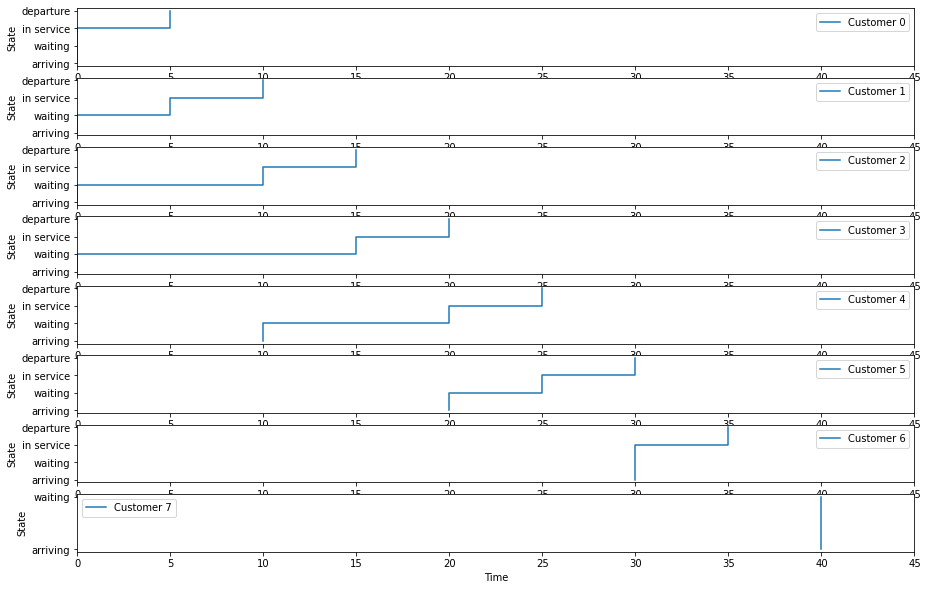

In [4]:
import matplotlib.pyplot as plt
df=pd.DataFrame(events, columns=['time','name','event'])

fig, axs = plt.subplots(len(df['name'].drop_duplicates()),1,figsize=(15,10))
for ax,c in zip(axs.flatten(),df['name'].drop_duplicates()):
    df_c=df.loc[df['name'] == c]
    
    ax.step(df_c['time'],df_c['event'], label=c)
    ax.set_xlabel('Time')
    ax.set_ylabel('State')  
    ax.set_xlim(0, 45)
    ax.legend()

#performance
print(df)
df_w=df.loc[df['event'] == 'waiting']
print('average waiting time: %.2f minutes.' % df_w.mean())

### Challenge 2: (D/D/n)

Now assume that the Bank has more than one service desks. By modifying the code above, model and simulate a Bank queueing system with n=3 service desks.

In [ ]:
import numpy.random as rnd
import simpy
import pandas as pd

# Constants
RANDOM_SEED = 42
NUM_DESKS = 3       # <<< NOW 3 desks!
SERVICETIME = 5     # Minutes to serve a customer
T_INTER = 10        # Customer arrives every 10 minutes
SIM_TIME = 45       # Total simulation time in minutes

events = []         # Event log

class Bank(object):
    """A Bank with multiple service desks."""
    def __init__(self, env, num_desks, service_time):
        self.env = env
        self.desk = simpy.Resource(env, num_desks)
        self.serviceTime = service_time

    def service(self, customer):
        """Service takes a fixed amount of time."""
        yield self.env.timeout(SERVICETIME)
        print("The Bank agent is serving %d%% of %s's service request." %
              (rnd.randint(75, 99), customer))
        events.append([env.now, customer, 'in service'])

def customer(env, name, bk):
    """Customer arrives and requests a desk."""
    print('%s arrives at the Bank at %.2f.' % (name, env.now))
    events.append([env.now, name, 'arriving'])

    with bk.desk.request() as request:
        yield request
        events.append([env.now, name, 'waiting'])
        print('%s is being served at %.2f.' % (name, env.now))
        
        yield env.process(bk.service(name))
        events.append([env.now, name, 'departure'])
        print('%s leaves the Bank at %.2f.' % (name, env.now))

def setup(env, num_desks, service_time, t_inter):
    """Create initial customers and generate new ones."""
    bk = Bank(env, num_desks, service_time)

    # Start with 4 customers
    for i in range(4):
        env.process(customer(env, 'Customer %d' % i, bk))

    # Generate new customers every T_INTER minutes

    while True:
        yield env.timeout(T_INTER)
        i += 1
        env.process(customer(env, 'Customer %d' % i, bk))

# Main simulation
print('Bank Simulation (D/D/3)')

env = simpy.Environment()
env.process(setup(env, NUM_DESKS, SERVICETIME, T_INTER))
env.run(until=SIM_TIME)


Bank Simulation (D/D/3)
Customer 0 arrives at the Bank at 0.00.
Customer 1 arrives at the Bank at 0.00.
Customer 2 arrives at the Bank at 0.00.
Customer 3 arrives at the Bank at 0.00.
Customer 0 is being served at 0.00.
Customer 1 is being served at 0.00.
Customer 2 is being served at 0.00.
The Bank agent is serving 93% of Customer 0's service request.
The Bank agent is serving 94% of Customer 1's service request.
The Bank agent is serving 87% of Customer 2's service request.
Customer 0 leaves the Bank at 5.00.
Customer 1 leaves the Bank at 5.00.
Customer 2 leaves the Bank at 5.00.
Customer 3 is being served at 5.00.
Customer 4 arrives at the Bank at 10.00.
The Bank agent is serving 89% of Customer 3's service request.
Customer 4 is being served at 10.00.
Customer 3 leaves the Bank at 10.00.
The Bank agent is serving 97% of Customer 4's service request.
Customer 4 leaves the Bank at 15.00.
Customer 5 arrives at the Bank at 20.00.
Customer 5 is being served at 20.00.
The Bank agent is s

### Challenge 3: (M/M/1 and M/M/n)
Now modify your code to model/simulate a Bank queueing system with the following queue type notation:
<ol type="I">
  <li>M/M/1 with arriving rate $\lambda=10$ and departure rate $\mu=5$</li>
  <li>M/M/3</li>
</ol>
Note that M/M/1 means both arriver and departure are Markovian (Exponential)

#### Hint:
The arriver and departure time is modeled using an exponential probability distribution. you can use either:
<ol type="I">
  <li>numpy.random.exponential(scale=rate)</li>
  <li>random.expovariate(1/rate)</li>
</ol>

--- Bank Simulation (M/M/1) ---
Customer 1 arrives at the Bank at 4.69.
Customer 1 is being served at 4.69.
The Bank agent is serving 95% of Customer 1's service request.
Customer 1 leaves the Bank at 11.28.
Customer 2 arrives at the Bank at 34.79.
Customer 2 is being served at 34.79.
The Bank agent is serving 85% of Customer 2's service request.
Customer 2 leaves the Bank at 35.64.
Customer 3 arrives at the Bank at 36.49.
Customer 3 is being served at 36.49.
The Bank agent is serving 82% of Customer 3's service request.
Customer 3 leaves the Bank at 38.52.
Customer 4 arrives at the Bank at 42.64.
Customer 4 is being served at 42.64.
The Bank agent is serving 76% of Customer 4's service request.
Customer 4 leaves the Bank at 42.74.
Customer 5 arrives at the Bank at 54.95.
Customer 5 is being served at 54.95.
Customer 6 arrives at the Bank at 67.75.
Customer 7 arrives at the Bank at 67.76.
The Bank agent is serving 75% of Customer 5's service request.
Customer 5 leaves the Bank at 68.90

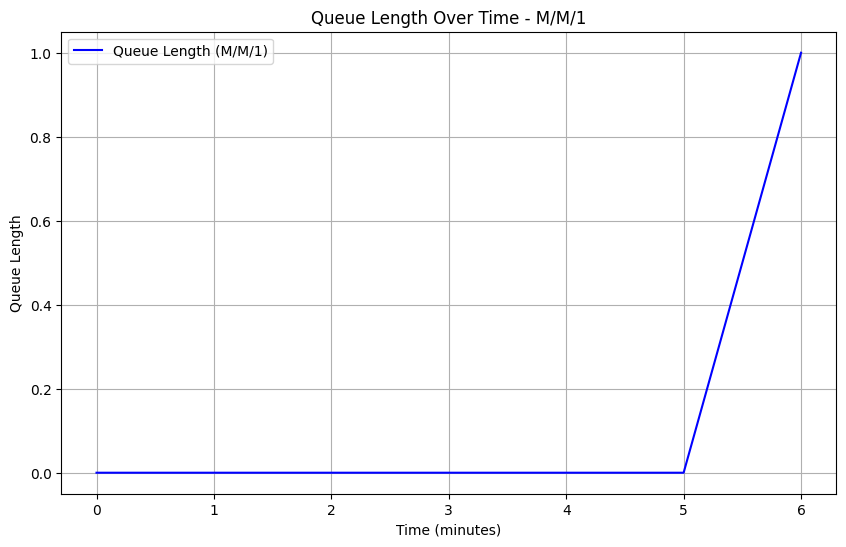

In [14]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuration for M/M/1
RANDOM_SEED = 42
NUM_DESKS = 1    # M/M/1 ➔ Only 1 service desk
LAMBDA = 10      # Mean arrival time (lambda)
MU = 5           # Mean service time (mu)
SIM_TIME = 100   # Total simulation time

events = []
queue_lengths = []  # To store queue length over time

class Bank:
    def __init__(self, env, num_desks, mu):
        self.env = env
        self.desk = simpy.Resource(env, num_desks)
        self.mu = mu

    def service(self, customer):
        service_time = np.random.exponential(self.mu)
        yield self.env.timeout(service_time)
        print(f"The Bank agent is serving {np.random.randint(75, 99)}% of {customer}'s service request.")
        events.append([env.now, customer, 'in service'])

def customer(env, name, bk):
    print(f'{name} arrives at the Bank at {env.now:.2f}.')
    events.append([env.now, name, 'arriving'])
    with bk.desk.request() as request:
        yield request
        events.append([env.now, name, 'waiting'])
        print(f'{name} is being served at {env.now:.2f}.')
        yield env.process(bk.service(name))
        events.append([env.now, name, 'departure'])
        print(f'{name} leaves the Bank at {env.now:.2f}.')

def setup(env, num_desks, lamda, mu):
    bk = Bank(env, num_desks, mu)
    i = 0
    while True:
        interarrival_time = np.random.exponential(lamda)
        yield env.timeout(interarrival_time)
        i += 1
        env.process(customer(env, f'Customer {i}', bk))
        # Track the queue length at each time step
        queue_lengths.append(len(bk.desk.queue))

print('--- Bank Simulation (M/M/1) ---')

np.random.seed(RANDOM_SEED)
env = simpy.Environment()
env.process(setup(env, NUM_DESKS, LAMBDA, MU))
env.run(until=SIM_TIME)

# (Optional) Pandas table of events
df = pd.DataFrame(events, columns=['Time', 'Customer', 'Event'])

# Plot the queue length over time
plt.figure(figsize=(10, 6))
plt.plot(range(len(queue_lengths)), queue_lengths, label="Queue Length (M/M/1)", color='blue')
plt.xlabel('Time (minutes)')
plt.ylabel('Queue Length')
plt.title('Queue Length Over Time - M/M/1')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuration for M/M/3
RANDOM_SEED = 42
NUM_DESKS = 3    # M/M/3 ➔ 3 service desks
LAMBDA = 10      # Mean arrival time (lambda)
MU = 5           # Mean service time (mu)
SIM_TIME = 100   # Total simulation time

events = []
queue_lengths = []  # To store queue length over time

class Bank:
    def __init__(self, env, num_desks, mu):
        self.env = env
        self.desk = simpy.Resource(env, num_desks)
        self.mu = mu

    def service(self, customer):
        service_time = np.random.exponential(self.mu)
        yield self.env.timeout(service_time)
        print(f"The Bank agent is serving {np.random.randint(75, 99)}% of {customer}'s service request.")
        events.append([env.now, customer, 'in service'])

def customer(env, name, bk):
    print(f'{name} arrives at the Bank at {env.now:.2f}.')
    events.append([env.now, name, 'arriving'])
    with bk.desk.request() as request:
        yield request
        events.append([env.now, name, 'waiting'])
        print(f'{name} is being served at {env.now:.2f}.')
        yield env.process(bk.service(name))
        events.append([env.now, name, 'departure'])
        print(f'{name} leaves the Bank at {env.now:.2f}.')

def setup(env, num_desks, lamda, mu):
    bk = Bank(env, num_desks, mu)
    i = 0
    while True:
        interarrival_time = np.random.exponential(lamda)
        yield env.timeout(interarrival_time)
        i += 1
        env.process(customer(env, f'Customer {i}', bk))
        # Track the queue length at each time step
        queue_lengths.append(len(bk.desk.queue))

print('--- Bank Simulation (M/M/3) ---')

np.random.seed(RANDOM_SEED)
env = simpy.Environment()
env.process(setup(env, NUM_DESKS, LAMBDA, MU))
env.run(until=SIM_TIME)

# (Optional) Pandas table of events
df = pd.DataFrame(events, columns=['Time', 'Customer', 'Event'])



--- Bank Simulation (M/M/3) ---
Customer 1 arrives at the Bank at 4.69.
Customer 1 is being served at 4.69.
The Bank agent is serving 95% of Customer 1's service request.
Customer 1 leaves the Bank at 11.28.
Customer 2 arrives at the Bank at 34.79.
Customer 2 is being served at 34.79.
The Bank agent is serving 85% of Customer 2's service request.
Customer 2 leaves the Bank at 35.64.
Customer 3 arrives at the Bank at 36.49.
Customer 3 is being served at 36.49.
The Bank agent is serving 82% of Customer 3's service request.
Customer 3 leaves the Bank at 38.52.
Customer 4 arrives at the Bank at 42.64.
Customer 4 is being served at 42.64.
The Bank agent is serving 76% of Customer 4's service request.
Customer 4 leaves the Bank at 42.74.
Customer 5 arrives at the Bank at 54.95.
Customer 5 is being served at 54.95.
Customer 6 arrives at the Bank at 67.75.
Customer 6 is being served at 67.75.
Customer 7 arrives at the Bank at 67.76.
Customer 7 is being served at 67.76.
The Bank agent is servin